In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import contextily as ctx
import numpy as np
import xarray as xr
from shapely.geometry import mapping

In [2]:
# get the shapefile of europ
path_rg = "data/NUTS_RG_01M_2021_4326_LEVL_0.shp"
gdf_rg = gpd.read_file(path_rg)

# set its coordinates system
gdf_rg.crs = "EPSG:4326"

<AxesSubplot:>

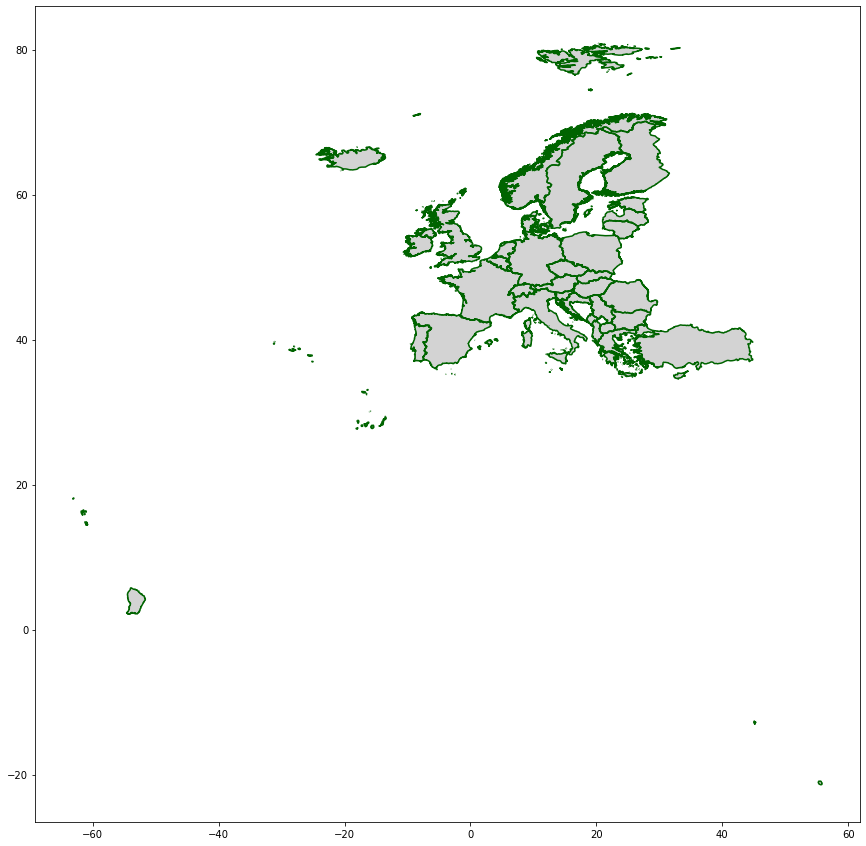

In [3]:
# plot the european shapefile
myplot = gdf_rg.plot(figsize=(20,15), color="lightgray")

# plot borders of these countries
gdf_rg.boundary.plot(color="darkgreen", ax = myplot)

In [4]:
# show the first five rows
gdf_rg.head()
#gdf_rg.tail()
#gdf_rg.loc[gdf_rg.CNTR_CODE=='CZ','MOUNT_TYPE']=1

gdf_rg[gdf_rg.CNTR_CODE=='CZ']


,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
0,CZ,0,CZ,Česko,Česko,0,None,0,CZ,"POLYGON ((14.49122 51.04353, 14.49945 51.04610..."


In [5]:
# get the Italy country geometry
gdf_it = gdf_rg[gdf_rg.CNTR_CODE == "IT"]
gdf_it

,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
18,IT,0,IT,Italia,Italia,0,None,0,IT,"MULTIPOLYGON (((12.24075 47.06917, 12.23652 47..."


In [6]:
# get the bounds of the country, we dont use this, just show the bounds, min-x,max-x,min-y,max-y
# if we use these bounds' value, we will get a rectangle range, it is not useful
it_bounds = gdf_it.bounds
it_bounds
# de_bounds.minx

,minx,miny,maxx,maxy
18,6.627429,35.493039,18.519314,47.091748


D:\Anconda\envs\GIS\lib\site-packages\contextily\tile.py:581: UserWarning: The inferred zoom level of 23 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


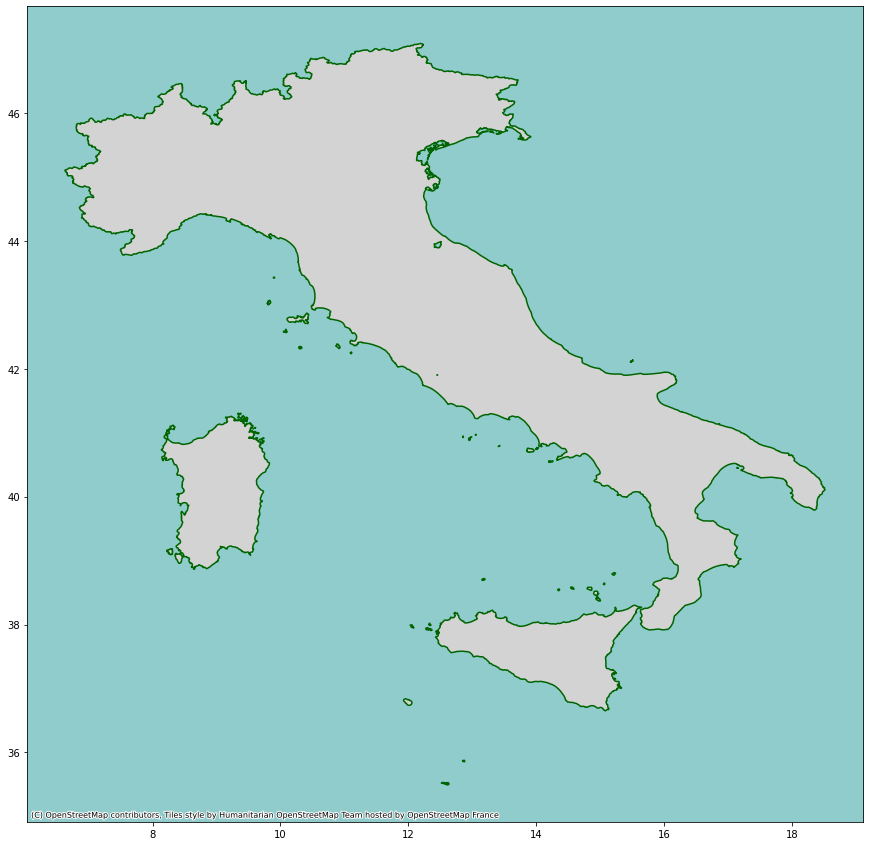

In [7]:
# show the italy
ax = gdf_it.plot(figsize=(20,15), color="lightgray")
# plot borders
gdf_it.boundary.plot(color="darkgreen", ax=ax)
# add basemap by OpenStreetMap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.HOT)

In [8]:
# import import numpy as np
# import pandas as pd
# import xarray as xr
# import geojson
# from shapely.geometry import mapping

### now we will use the shapefile to cut the xarray dataset

In [9]:
# load the result of the pollutant
# before this step we need to discuess which the dataset we need to change,cuz currently it's not working
# and how to request the result dont download it maybe use another api
data = xr.open_dataset("data/download.nc")
data.rio.write_crs("epsg:4326", inplace=True) # set crs 

<xarray.Dataset>
Dimensions:      (longitude: 700, latitude: 420, level: 1, time: 1)
Coordinates:
  * longitude    (longitude) float32 335.0 335.1 335.2 ... 44.75 44.85 44.95
  * latitude     (latitude) float32 71.95 71.85 71.75 ... 30.25 30.15 30.05
  * level        (level) float32 0.0
  * time         (time) timedelta64[ns] 00:00:00
    spatial_ref  int32 0
Data variables:
    pm2p5_conc   (time, level, latitude, longitude) float32 ...
Attributes:
    title:        PM25 Air Pollutant ANALYSIS at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE ANALYSIS
    ANALYSIS:     Europe, 20220322+[0H_0H]
    summary:      ENSEMBLE model hourly ANALYSIS of PM25 concentration at the...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

In [ ]:
# trans the longitude from [0,360] to [-180,180] this is important
data = data.assign_coords(longitude=(((data.longitude + 180) % 360) - 180)).sortby('longitude')
data

In [ ]:
# get the italy shape
gdf_nation= gdf_rg[gdf_rg.CNTR_CODE == "IT"]
gdf_nation

In [ ]:
# cc = xr.DataArray(data.pm2p5_conc)
# cc.rio.write_crs("epsg:4326", inplace=True)
# cc

In [ ]:
print('clip...')
clipped = data.rio.clip(gdf_nation.geometry.apply(mapping),'epsg:4326',all_touched=False)
clipped

In [ ]:
r_values = clipped.pm2p5_conc.values
pd.DataFrame(r_values[0][0]).to_csv("clipped.csv")